In [56]:
import pandas as pd
import statsmodels.api as sm
import re
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score


In [25]:
full_dataset = pd.read_csv('archive/Loan_status_2007-2020Q3.gzip')

/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
full_dataset.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [85]:
full_dataset['issue_d'] = pd.to_datetime(full_dataset['issue_d'])
mask = (full_dataset['issue_d'] > '2014-01-01') & (full_dataset['issue_d'] <= '2015-01-01')
small_dataset = full_dataset[mask]

In [100]:
columns = ['annual_inc', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'funded_amnt', 
           'home_ownership', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'pub_rec',
           'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'term', 'total_acc', 'verification_status', 'loan_status']
df = small_dataset[columns]


In [101]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'Late (31-120 days)',
       'Default', 'In Grace Period'], dtype=object)

In [88]:
df['purpose'].unique()

array(['credit_card', 'debt_consolidation', 'car', 'house',
       'home_improvement', 'other', 'medical', 'major_purchase', 'moving',
       'vacation', 'small_business', 'renewable_energy', 'wedding'],
      dtype=object)

In [102]:
def clean_data(X):
    X = X.dropna()
    X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
    X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
    X['term'] = [float(re.sub('[a-zA-Z ]*', '', str(string))) for string in X['term']]
    X['home_ownership'] = (X['home_ownership'] == 'OWN').astype('int')
    X['verification_status'] = (X['verification_status'] != 'Verified') | (X['verification_status'] != 'Source Verified')
    X['verification_status'] = X['verification_status'].astype('int')
    # Remove emp title, issue_d before regression is run, can also try get_dummies for emp_title (Maybe just a few professions or types)
    # Drop funded amount since it is equal to loan amount for our data (Makes matrix singular), all are verified 
    X = X.drop(columns=['emp_title', 'issue_d','funded_amnt', 'verification_status'])
    
    
    #X['loan_status'] = (X['loan_status'] == 'Current') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'In Grace Period')
    
#     There are so few defaults that instead I think we should do if the loan is paid/current
    mask = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Fully Paid') | (X['loan_status'] == 'Charged Off')
    X = X[mask]
    X['loan_status'] = (X['loan_status'] == 'Default') | (X['loan_status'] == 'Charged Off')
    X['loan_status'] = X['loan_status'].astype('int')
    
    
    
    #Just select the categorical variables
    cat_vars = ['purpose']

    #Create dummy variables for each cat. variable
    for var in cat_vars:
        cat_list = pd.get_dummies(X[var], prefix=var)
        # Categorical variables that have low count are making matrix singular
        for col in cat_list.columns:
            if sum(cat_list[col]) <= 50:
                cat_list = cat_list.drop(columns=[col])
        X=X.join(cat_list)
        
        

    X = X.drop(columns = cat_vars)
    
    return X
  


In [83]:
# Wrote own function to preserve column names
def normalize(X):
    return (X-X.min())/(X.max()-X.min())

In [103]:
df = clean_data(df[:100000])

<ipython-input-102-1c91b5502a01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['emp_length'] = [float(re.sub('[a-zA-Z +<]*', '', str(string))) for string in X['emp_length']]
<ipython-input-102-1c91b5502a01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int_rate'] = [float(re.sub('[a-zA-Z %]*', '', str(string))) for string in X['int_rate']]
<ipython-input-102-1c91b5502a01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [35]:
df

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
1485415,58000.0,0.0,0.0,14.92,8.0,0,2.0,321.08,6.99,10400.0,...,0,0,0,0,0,0,0,0,0,0
1485416,78000.0,0.0,0.0,12.03,10.0,0,0.0,336.64,12.39,15000.0,...,1,0,0,0,0,0,0,0,0,0
1485417,69000.0,0.0,0.0,25.81,10.0,0,0.0,326.53,13.66,9600.0,...,1,0,0,0,0,0,0,0,0,0
1485418,125000.0,0.0,1.0,8.31,10.0,0,0.0,319.08,17.14,12800.0,...,0,0,0,0,0,0,0,0,0,0
1485419,63800.0,0.0,0.0,18.49,6.0,0,0.0,516.36,15.59,21425.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585410,73000.0,0.0,0.0,16.95,7.0,0,0.0,626.90,15.61,26000.0,...,1,0,0,0,0,0,0,0,0,0
1585411,48000.0,0.0,0.0,12.25,10.0,0,0.0,261.64,14.99,11000.0,...,0,0,0,0,0,0,0,0,0,0
1585412,96000.0,0.0,0.0,9.74,2.0,0,0.0,694.20,11.67,21000.0,...,0,0,0,0,0,0,0,0,0,0
1585413,85000.0,0.0,0.0,20.40,1.0,0,0.0,274.97,10.99,8400.0,...,0,0,0,0,0,0,1,0,0,0


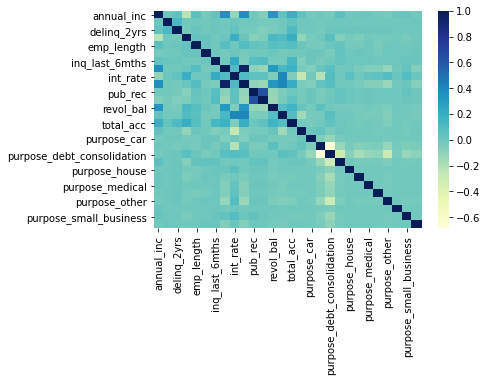

In [36]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap="YlGnBu")
plt.show()

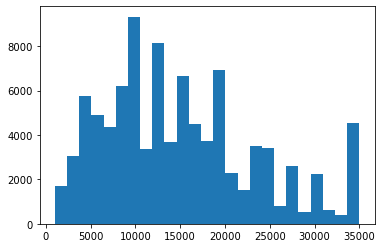

In [37]:
plt.hist(df['loan_amnt'], bins=25)
plt.show()

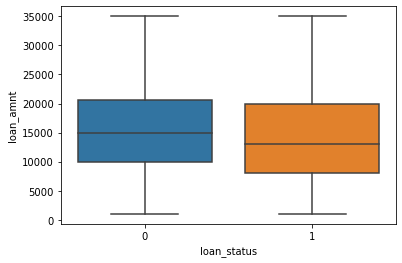

In [38]:
ax = sn.boxplot(y=df['loan_amnt'], x=df['loan_status'])

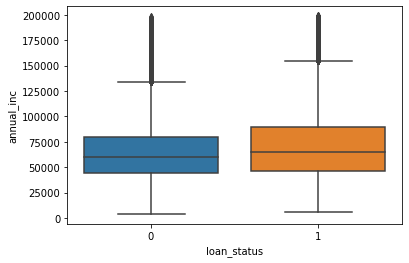

In [39]:
boxplot_df = df[df['annual_inc'] < 2*10**5] 
ax = sn.boxplot(y=boxplot_df['annual_inc'], x=boxplot_df['loan_status'])

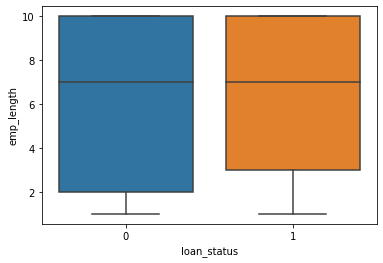

In [40]:
ax = sn.boxplot(y=df['emp_length'], x=df['loan_status'])

In [41]:
df.describe()

,annual_inc,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
count,9.469000e+04,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,...,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000,94690.000000
mean,7.606553e+04,0.010212,0.347745,18.687679,6.148474,0.098363,0.622537,441.369827,13.257025,15053.951051,...,0.620541,0.050713,0.003337,0.016697,0.009505,0.006400,0.047101,0.000708,0.008977,0.004721
std,5.886480e+04,0.110832,0.911898,8.500398,3.549330,0.297807,0.915039,244.765605,4.391573,8518.500573,...,0.485255,0.219412,0.057672,0.128133,0.097028,0.079743,0.211856,0.026591,0.094320,0.068545
min,4.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30.420000,6.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000e+04,0.000000,0.000000,12.270000,3.000000,0.000000,0.000000,264.460000,10.150000,8400.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500000e+04,0.000000,0.000000,18.120000,7.000000,0.000000,0.000000,384.340000,12.990000,13512.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000e+04,0.000000,0.000000,24.630000,10.000000,0.000000,1.000000,578.420000,15.610000,20000.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.500000e+06,4.000000,22.000000,39.990000,10.000000,1.000000,6.000000,1408.130000,26.060000,35000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
train, test = train_test_split(df, train_size=0.80, random_state=1)
train = train.fillna(0)
test = test.fillna(0)
X = train.drop(columns=['loan_status'])
# Normalize Data (Using min max)
X = normalize(X)
# Note: Could also try multinomial logistic regression since the loan status doesnt necessarily have to be 0 or 1
# Perhaps cluster robust estimator by loan purpose or some other variable
Y = train['loan_status']
# Add regulariztion since otherwise with the normalized variables it wont converge
log_reg = sm.Logit(Y, X).fit_regularized()
clf = LogisticRegression(class_weight = 'balanced').fit(X,Y)
# results = log_reg

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4325799699396384
            Iterations: 237
            Function evaluations: 237
            Gradient evaluations: 237


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [425]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                75752
Model:                          Logit   Df Residuals:                    75725
Method:                           MLE   Df Model:                           26
Date:                Sat, 08 May 2021   Pseudo R-squ.:                 0.07580
Time:                        16:27:37   Log-Likelihood:                -32865.
converged:                       True   LL-Null:                       -35561.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
annual_inc                     6.7445      2.225      3.032      0.002       2.384      11.105
chargeoff_within_12_mths      -0.3346      0.347     -0.963      0.336      -1.016       0.346
delinq_2yrs                   -0.4704      0.235     -2.004      0.045      -0.930      -0.010
dti                           -0.8233      0.052    -15.807      0.000      -0.925      -0.721
emp_length                     0.0508      0.025      1.998      0.046       0.001       0.101
home_ownership                -0.0177      0.033     -0.535      0.593      -0.082       0.047
inq_last_6mths                -0.3273      0.065     -5.062      0.000      -0.454      -0.201
installment                   -1.4168      0.352     -4.023      0.000      -2.107      -0.727
int_rate                      -2.3112      0.067    -34.419      0.000      -2.443      -2.180
loan_amnt                      0.9835      0.272      3.618      0.000       0.451       1.516
pub_rec                       -0.7480      0.390     -1.918      0.055      -1.512       0.016
pub_rec_bankruptcies          -0.5818      0.407     -1.429      0.153      -1.380       0.216
revol_bal                     11.9707      1.716      6.978      0.000       8.608      15.333
term                          -0.5079      0.052     -9.753      0.000      -0.610      -0.406
total_acc                      0.1398      0.138      1.013      0.311      -0.131       0.410
purpose_car                    3.2656      0.133     24.519      0.000       3.005       3.527
purpose_credit_card            2.8872      0.044     64.929      0.000       2.800       2.974
purpose_debt_consolidation     2.9395      0.043     68.016      0.000       2.855       3.024
purpose_home_improvement       3.0012      0.061     48.803      0.000       2.881       3.122
purpose_house                  3.2180      0.163     19.696      0.000       2.898       3.538
purpose_major_purchase         2.8536      0.086     33.301      0.000       2.686       3.022
purpose_medical                2.9518      0.108     27.356      0.000       2.740       3.163
purpose_moving                 2.8739      0.120     24.003      0.000       2.639       3.109
purpose_other                  3.1034      0.062     50.214      0.000       2.982       3.225
purpose_renewable_energy       2.5943      0.312      8.314      0.000       1.983       3.206
purpose_small_business         2.8213      0.102     27.769      0.000       2.622       3.020
purpose_vacation               2.9281      0.147     19.906      0.000       2.640       3.216
==============================================================================================
"""

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.505


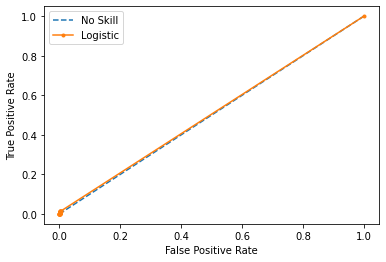

In [105]:
# TO-DO: Precision Recall is better since we have a large class imbalance 
X_test = test.drop(columns=['loan_status'])
X_test = normalize(X_test)
y_test = test['loan_status']
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = log_reg.predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = lr_probs * (lr_probs > .5)
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [114]:
w = {0:1, 1:2}
clf = LogisticRegression(class_weight = w)
clf.fit(X,Y)
preds = clf.predict(X_test)

accuracy = np.mean(y_test == preds)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.55%


/Users/jasonnyam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
lr_probs = log_reg.predict(X_test)
lr_probs = lr_probs.reset_index(drop=True)
lr_probs = (lr_probs > .5).astype('int')
accuracy = np.mean(y_test == lr_probs)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: Can only compare identically-labeled Series objects

In [116]:
np.sum(preds==1)

1493

In [78]:
(lr_probs > .5).astype('int') == y_test

ValueError: Can only compare identically-labeled Series objects

In [ ]:
lr

In [79]:
np.mean(y_test == 1)

0.8223149223782871